# Initial Setup: Import Libraries and Data

In [1]:
# Import Libraries
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np

# Set the paths to the data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read in the data files as dataframes
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Merge the mouse and study dataframes into a single dataframe
merged_df = pd.merge(mouse_metadata, study_results, how = "left", on = ["Mouse ID"])

In [2]:
# We need to check for duplicates twice, so it would be cool to
# try defining a function. Here's "Able_and_Baker", named for my cats.
# Much like the actual cats, Able_and_Baker can let you know if there's a (duplicate) mouse around,
# but won't do much about it.

def Able_and_Baker(data_frame, series_1, series_2, starting_line):
# data_frame is the data frame we are searching in.
# series_1 is the series for which we are interested in duplicate values.
# series_2 is a series for which we know we can count on a point
# at which the series_1 duplicates will all be present.
# starting_line is the series_2 value at which the series_1 duplicates meet.
    
    # First, count the number of unique Mouse IDs (unique values in series_1)
    unique_mice = data_frame[str(series_1)].nunique()
    print(f"There are {unique_mice} {series_1}'s in the study.")
    
    # Now, count how many mice started the study, i.e. how many Mouse IDs
    # appear for the condition Timecount == 0.
    number_of_subjects = data_frame[data_frame[str(series_2)] == starting_line].count()[series_1]
    print(f"There are {number_of_subjects} mice in the results.")

    # If there are more mice than IDs, then there must be a duplicate.
    if number_of_subjects > unique_mice:
        print(f"There are more mice than mouse IDs, which means that there is at least one duplicate!")
    # If not, then we cannot claim the presence of duplicates.
    else:
        print(f"This does not indicate the presence of duplicates.")

In [3]:
Able_and_Baker(merged_df, "Mouse ID", "Timepoint", 0)

There are 249 Mouse ID's in the study.
There are 250 mice in the results.
There are more mice than mouse IDs, which means that there is at least one duplicate!


In [4]:
# Now let's find that duplicate mouse.
# We know that the Mouse ID is duplicated, but we don't know anything about the data that follows.
# So we'll find the duplicated Mouse ID at Timepoint == 0, and then get rid of all rows matching that Mouse ID.
# We know that there is only one duplicate, and we also know that df.value_counts() returns a series sorted
# in descending order by number of occurences. Which is to say that the first key in that series is our duplicate.

dup_finder = merged_df[merged_df["Timepoint"] == 0]["Mouse ID"].value_counts()
dup_mouse = dup_finder.keys().tolist()[0]

In [5]:
# We'll keep the data for the duplicate mouse off to the side in case
# anyone wants to look at what has been excluded from the analysis.
# We aren't doing anything with it, but we could save it as a csv if
# someone wanted to take a look at it.
excluded_data = merged_df.copy().loc[merged_df['Mouse ID'] == dup_mouse, :]

In [6]:
# Now let's remove the records for the duplicate mouse.
clean_df = merged_df.copy().loc[merged_df['Mouse ID'] != dup_mouse, :]

# and repeat our check from before, but now on the cleaned dataframe.
Able_and_Baker(clean_df, "Mouse ID", "Timepoint", 0)

There are 248 Mouse ID's in the study.
There are 248 mice in the results.
This does not indicate the presence of duplicates.


### Summary Statistics

In [7]:
# We'll get the summary statistics from a grouped copy of the clean dataframe.
drug_group = clean_df.copy().groupby('Drug Regimen')

In [8]:
# We're asked for mean, median, standard deviation, and SEM of the tumor volume.
# That's easy enough to piece together
drug_group_df = pd.DataFrame(drug_group['Tumor Volume (mm3)'].mean())
drug_group_df['Median'] = drug_group['Tumor Volume (mm3)'].median()
drug_group_df['Standard Deviation'] = drug_group['Tumor Volume (mm3)'].std()
drug_group_df['SEM'] = drug_group['Tumor Volume (mm3)'].sem()
# Fix the column heading on the first series we generated.
drug_group_df.rename(columns = {'Tumor Volume (mm3)':'Mean'}, inplace = True)
# Display the result.
drug_group_df

,Mean,Median,Standard Deviation,SEM
Drug Regimen,,,,
Capomulin,40.675741,41.557809,4.994774,0.329346
Ceftamin,52.591172,51.776157,6.268188,0.469821
Infubinol,52.884795,51.820584,6.567243,0.492236
Ketapril,55.235638,53.698743,8.279709,0.603860
Naftisol,54.331565,52.509285,8.134708,0.596466
Placebo,54.033581,52.288934,7.821003,0.581331
Propriva,52.320930,50.446266,6.622085,0.544332
Ramicane,40.216745,40.673236,4.846308,0.320955
Stelasyn,54.233149,52.431737,7.710419,0.573111


### Bar Plots

In [9]:
# We'll start with a copy of the clean dataframe.
bar_group_df = clean_df.copy()

In [10]:
bar_group_df = bar_group_df.loc[:, ['Drug Regimen', 'Timepoint', 'Mouse ID']]

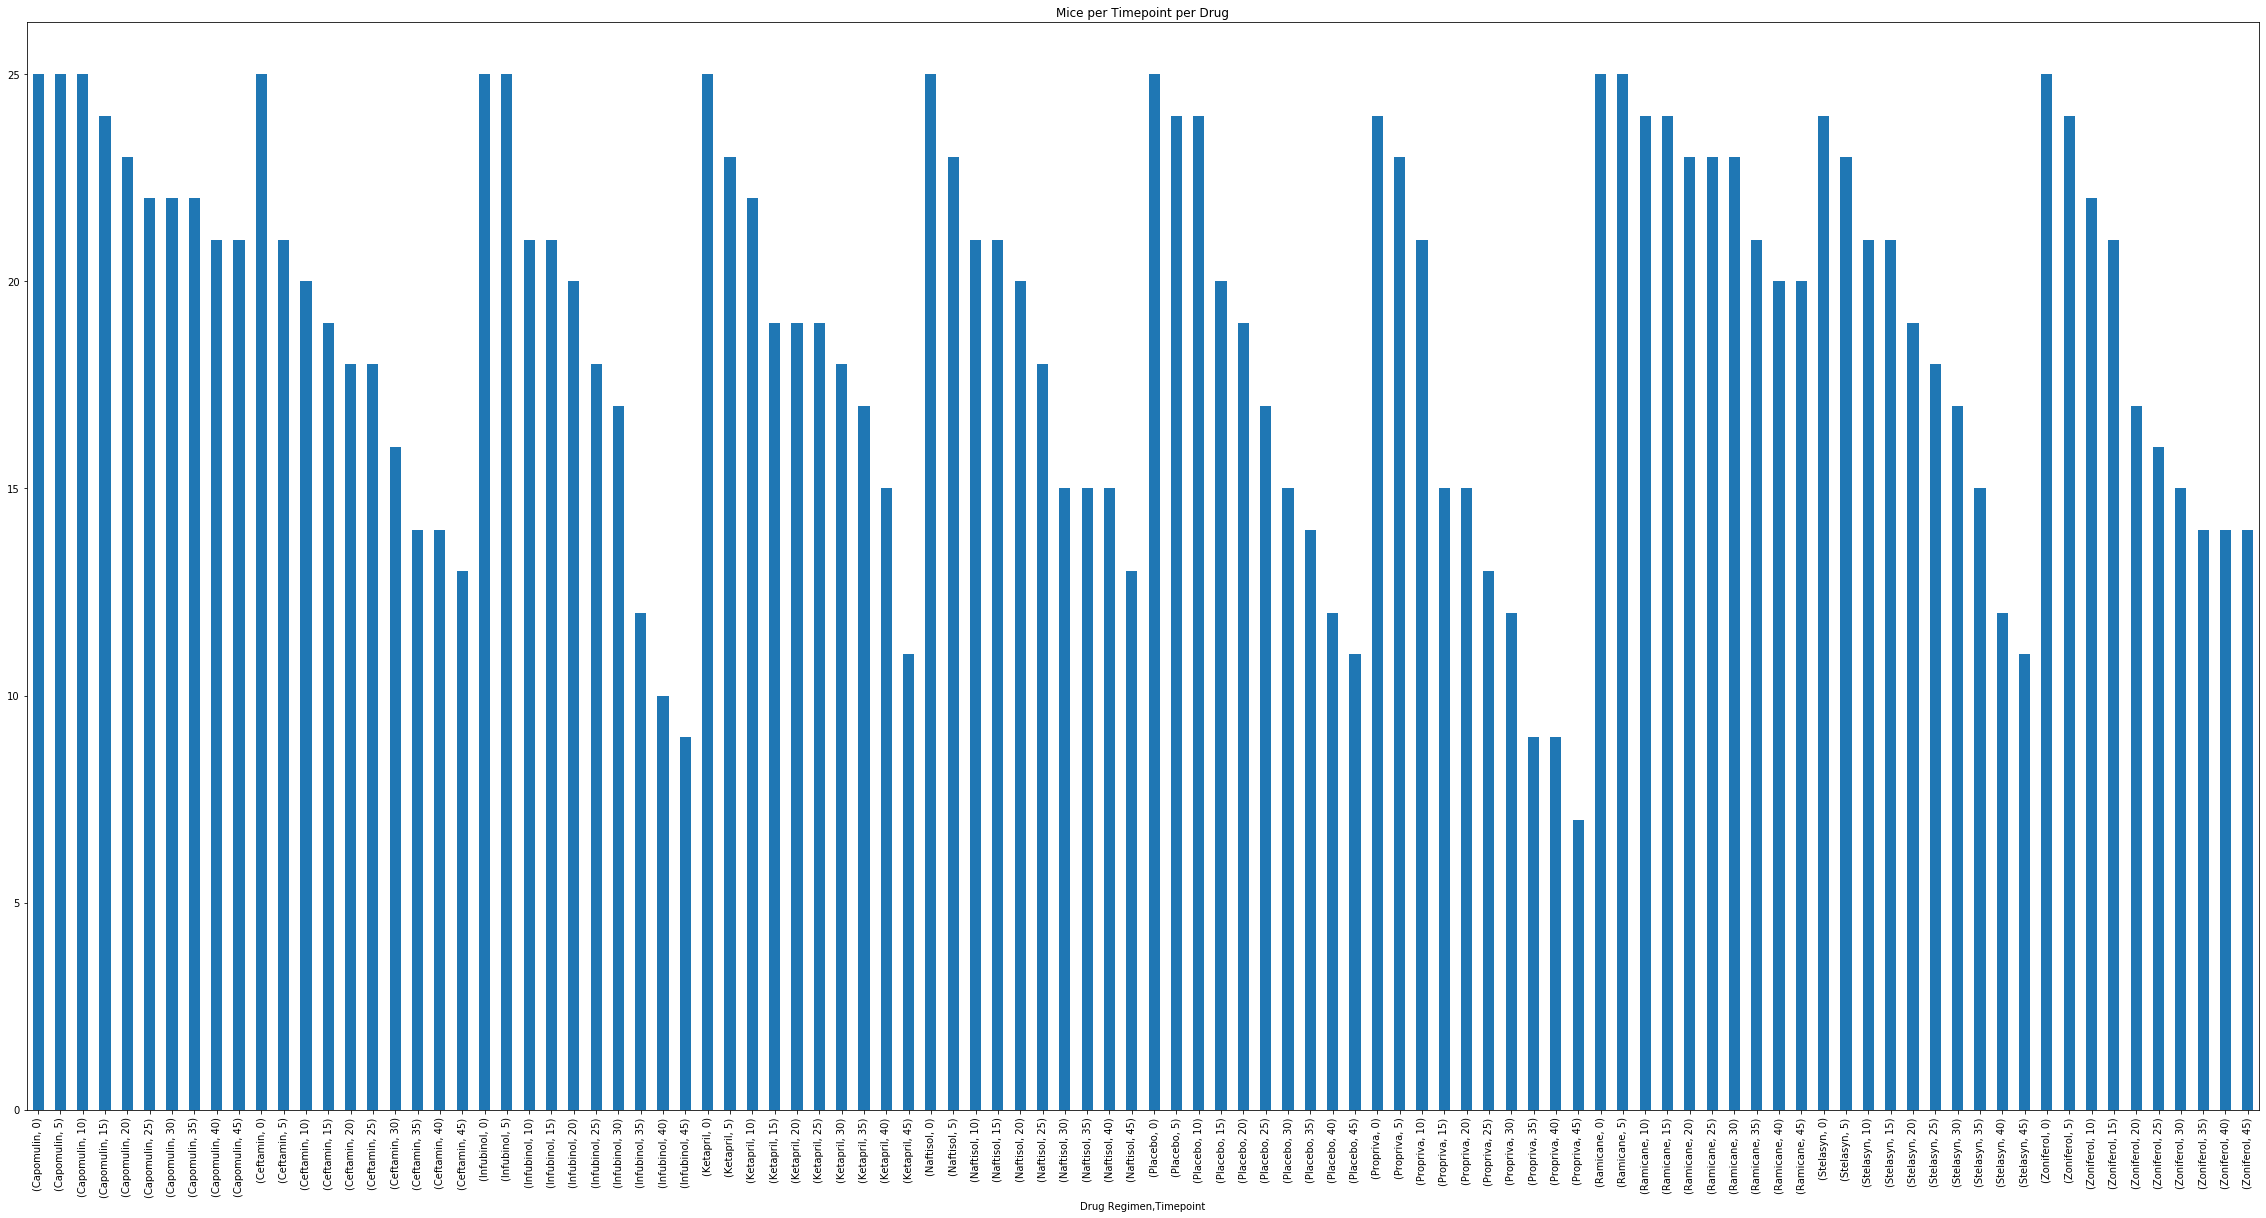

In [11]:
# First, using pandas.plot:
# The readme asks for "...number of mice per time point for each treatment regimen...",
# So let's trim this dataframe down to drug regimen, timepoint, and mouse ID.
bar_group_df = bar_group_df.loc[:, ['Drug Regimen', 'Timepoint', 'Mouse ID']]
# group by regien and timepoint, and then count the mice
plot_aid_df = bar_group_df.groupby(['Drug Regimen','Timepoint']).count()
# now plot it
plot_aid_df.plot(kind = 'bar', title = "Mice per Timepoint per Drug", legend = False, figsize = (40,20))
plt.show()

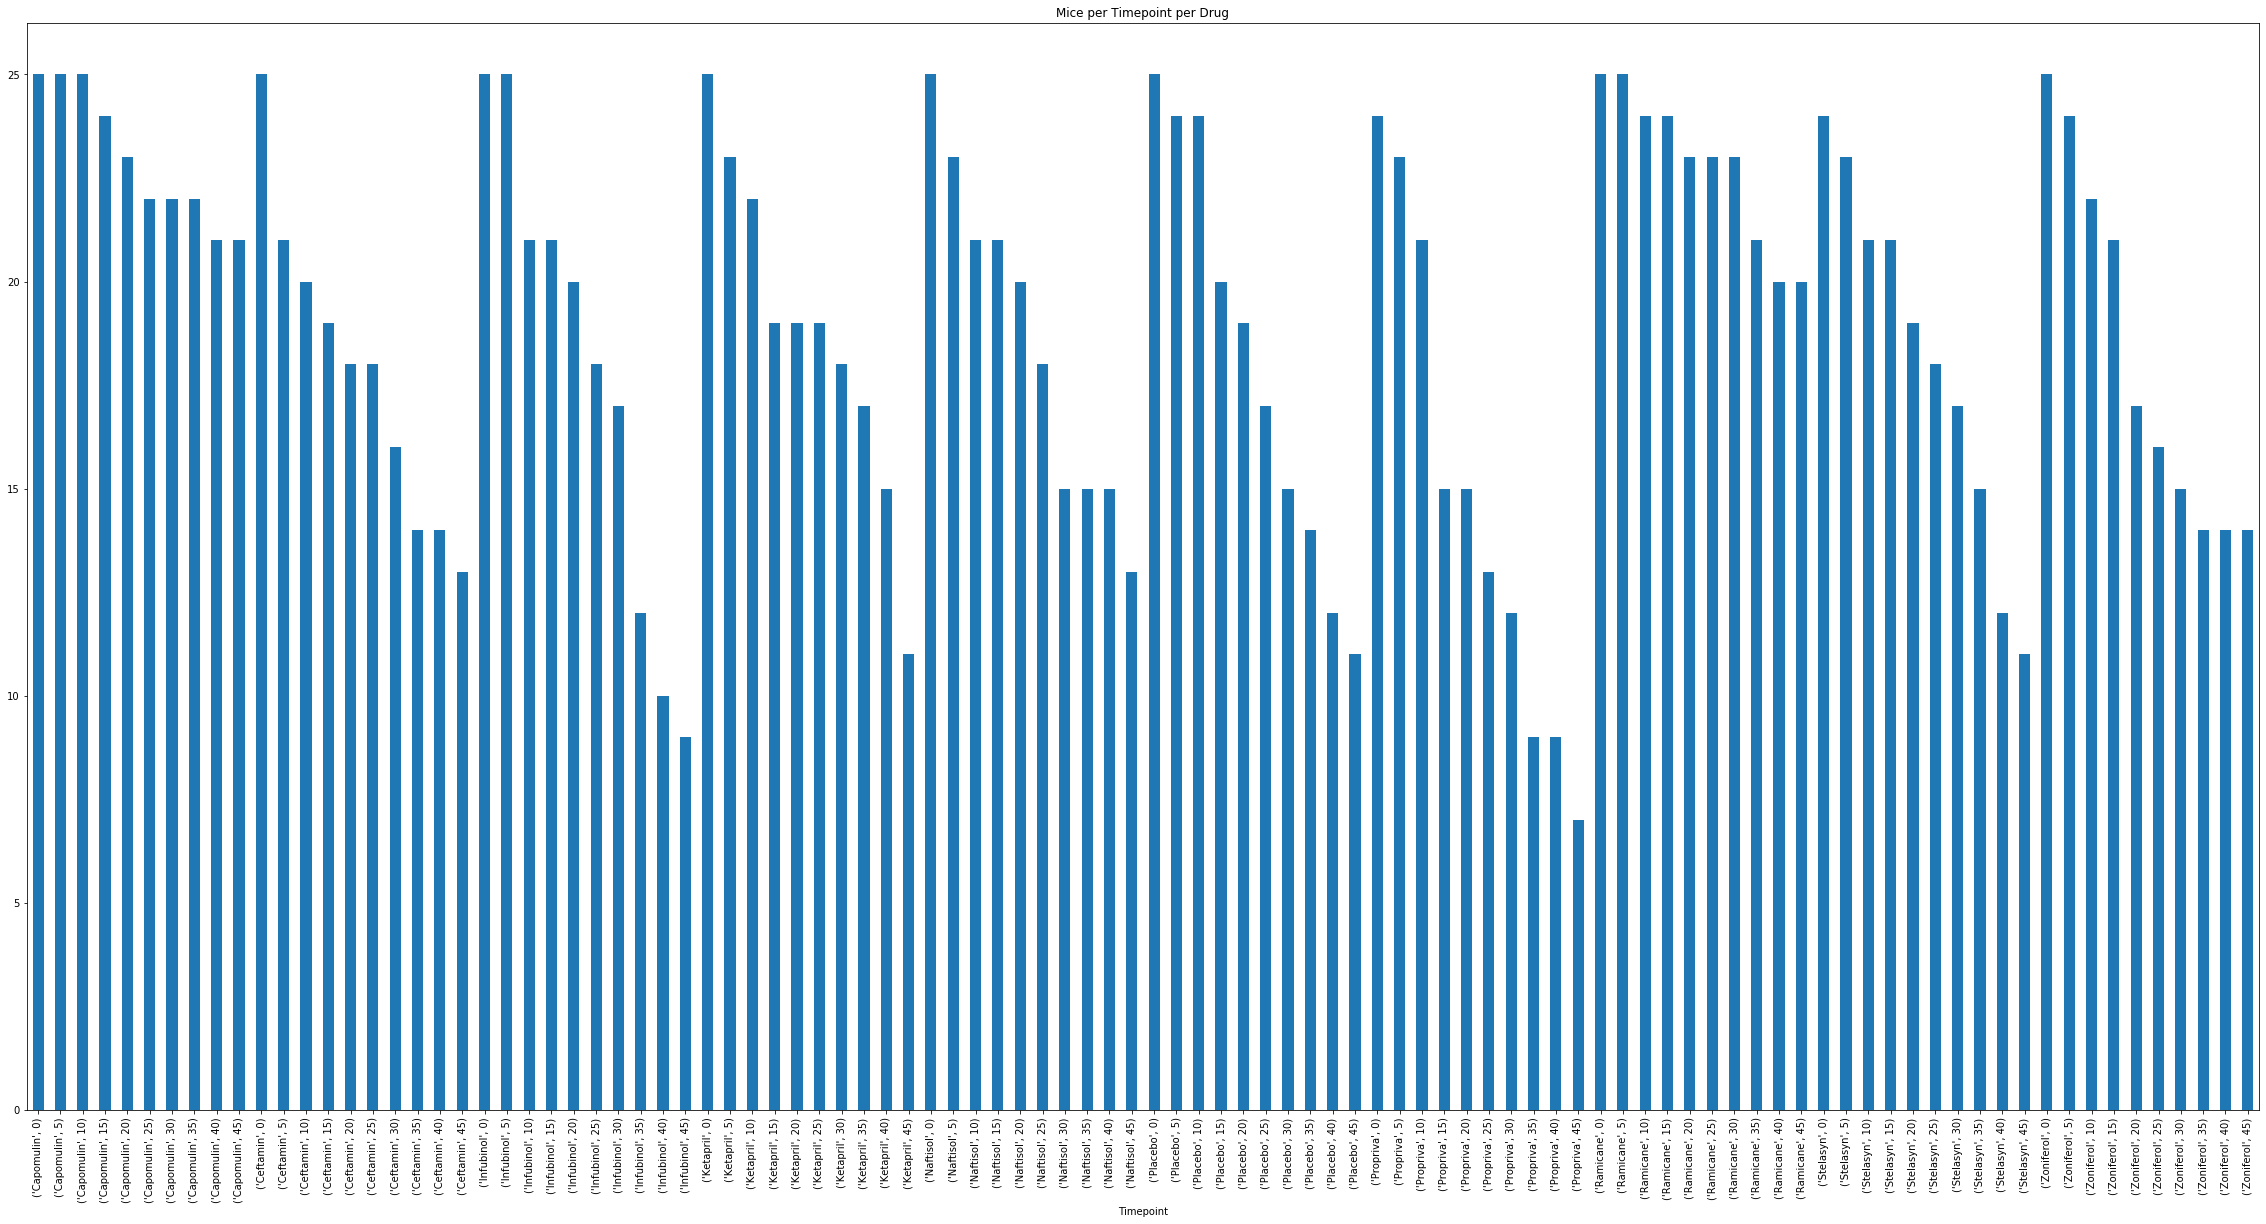

In [12]:
# and now do the same thing with matplotlib.
# There is admittedly a lot of trial and error here to get the look right.
plt.figure(figsize = (40,20))
x_axis = np.arange(len(plot_aid_df.index.tolist()))
plt.bar(x_axis, plot_aid_df['Mouse ID'], color='tab:blue', width = 0.5, align="center")
plt.title("Mice per Timepoint per Drug")
plt.xlabel("Timepoint")
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, plot_aid_df.index.tolist(), rotation = 'vertical')
plt.xlim(-0.5,len(plot_aid_df)-.5)
plt.show()

### Pie Charts

In [13]:
# First, we're going to need the distribution of male and female mice
# We'll use this series in the twp plots
sex_series = clean_df.copy()['Sex'].value_counts()

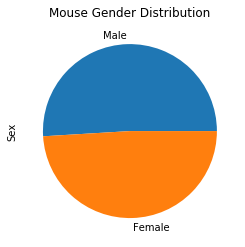

In [14]:
# First we plt this using pandas.plot
sex_series.plot(kind = 'pie', title = "Mouse Gender Distribution", )
plt.show()

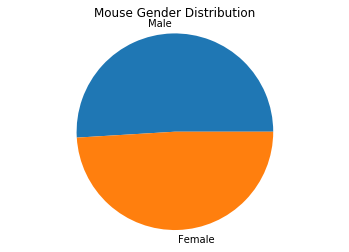

In [15]:
# Now using matplotlib.
# This time we'll extract two lists from the series to feed them back in as the values and labels for the pie.
sex_count = sex_series.tolist()
mouse_genders = sex_series.index.tolist()
plt.title("Mouse Gender Distribution")
plt.pie(sex_series, labels=mouse_genders)
plt.axis("equal")
plt.show()

### Quartiles, Outliers and Boxplots

In [16]:
# Here, we are going to be focusing on the four most promising treatments:
# Capomulin, Ramicane, Infubinol, and Ceftamin
# So, first, let's get a dataframe that has just those drugs
qob_df = clean_df.copy()
# Peeking ahead, we know we'll only need certain columns.
qob_df = qob_df.loc[(qob_df['Drug Regimen'] == 'Capomulin') | (qob_df['Drug Regimen'] == 'Ramicane') | (qob_df['Drug Regimen'] == 'Infubinol') | (qob_df['Drug Regimen'] == 'Ceftamin'), ['Mouse ID', 'Drug Regimen', 'Weight (g)', 'Timepoint', 'Tumor Volume (mm3)']]

In [17]:
# The first ask is final tumor volume by mouse
# The readme isn't crystal clear on how this is defined.
# Do mice that don't make it to the end of the study count?
# I'm going to assume that "final tumor volume" is the last
# recorded tumor volume of every mouse that started the study.
# Thanks to an old Stackoverflow post, I can do that.
# https://stackoverflow.com/questions/15705630/get-the-rows-which-have-the-max-count-in-groups-using-groupby
# What I'm doing here is looking for rows with the maximum timepoint for each mouse ID.
# In other words, I'm looking for the last measurement from each mouse, and then
# collecting that in a dataframe of final tumor volumes (ftv_df).

idx = qob_df.groupby(['Mouse ID'])['Timepoint'].transform(max) == qob_df['Timepoint']
ftv_df = qob_df[idx]


ftv_rpt_df = ftv_df.copy().loc[:,['Mouse ID', 'Tumor Volume (mm3)']]
ftv_rpt_df.set_index('Mouse ID', inplace = True)
ftv_rpt_df

,Tumor Volume (mm3)
Mouse ID,
k403,22.050126
s185,23.343598
x401,28.484033
m601,28.430964
g791,29.128472
...,...
x822,61.386660
y163,67.685569
y769,68.594745


In [18]:
# Now let's get the quartiles, IQR, and outliers for each of the selected drugs
drug_list = ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']
# We'll save all the values for later in case we need them.
stats_dict = {}
for drug in drug_list:
    quartiles = ftv_df.loc[ftv_df['Drug Regimen'] == drug]['Tumor Volume (mm3)'].quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq
    print(f"---------- {drug} Summary Stats Report ----------")
    print(f"The lower quartile of final tumor volume for {drug} is: {lowerq} mm3.")
    print(f"The upper quartile of final tumor volume for {drug} is: {upperq} mm3.")
    print(f"The interquartile range of final tumor volume for {drug} is: {iqr} mm3.")
    print(f"The the median of final tumor volume for {drug} is: {quartiles[0.5]} mm3.")

    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    print(f"Values below {lower_bound} could be outliers.")
    print(f"Values above {upper_bound} could be outliers.")
    print(f"-------------------------------------------------")
    stats_dict[drug] = {'lowerq':lowerq, 'median':quartiles[0.5], 'upperq':upperq, 'iqr':iqr, 'lower_bound':lower_bound, 'upper_bound':upper_bound}
    print()

---------- Capomulin Summary Stats Report ----------
The lower quartile of final tumor volume for Capomulin is: 32.37735684 mm3.
The upper quartile of final tumor volume for Capomulin is: 40.1592203 mm3.
The interquartile range of final tumor volume for Capomulin is: 7.781863460000004 mm3.
The the median of final tumor volume for Capomulin is: 38.125164399999996 mm3.
Values below 20.70456164999999 could be outliers.
Values above 51.83201549 could be outliers.
-------------------------------------------------

---------- Ramicane Summary Stats Report ----------
The lower quartile of final tumor volume for Ramicane is: 31.56046955 mm3.
The upper quartile of final tumor volume for Ramicane is: 40.65900627 mm3.
The interquartile range of final tumor volume for Ramicane is: 9.098536719999998 mm3.
The the median of final tumor volume for Ramicane is: 36.56165229 mm3.
Values below 17.912664470000003 could be outliers.
Values above 54.30681135 could be outliers.
-------------------------------

In [19]:
# Now let's find the outliers
# turns out there's only one.
outliers_df = ftv_df.loc[((ftv_df['Drug Regimen'] == drug_list[0]) & (ftv_df['Tumor Volume (mm3)'] < stats_dict[drug_list[0]]['lower_bound'])) |
                        ((ftv_df['Drug Regimen'] == drug_list[0]) & (ftv_df['Tumor Volume (mm3)'] > stats_dict[drug_list[0]]['upper_bound'])) |
                        ((ftv_df['Drug Regimen'] == drug_list[1]) & (ftv_df['Tumor Volume (mm3)'] < stats_dict[drug_list[1]]['lower_bound'])) |
                        ((ftv_df['Drug Regimen'] == drug_list[1]) & (ftv_df['Tumor Volume (mm3)'] > stats_dict[drug_list[1]]['upper_bound'])) |
                        ((ftv_df['Drug Regimen'] == drug_list[2]) & (ftv_df['Tumor Volume (mm3)'] < stats_dict[drug_list[2]]['lower_bound'])) |
                        ((ftv_df['Drug Regimen'] == drug_list[2]) & (ftv_df['Tumor Volume (mm3)'] > stats_dict[drug_list[2]]['upper_bound'])) |
                        ((ftv_df['Drug Regimen'] == drug_list[3]) & (ftv_df['Tumor Volume (mm3)'] < stats_dict[drug_list[3]]['lower_bound'])) |
                        ((ftv_df['Drug Regimen'] == drug_list[3]) & (ftv_df['Tumor Volume (mm3)'] > stats_dict[drug_list[3]]['upper_bound'])) ]
outliers_df

,Mouse ID,Drug Regimen,Weight (g),Timepoint,Tumor Volume (mm3)
669,c326,Infubinol,25,5,36.321346


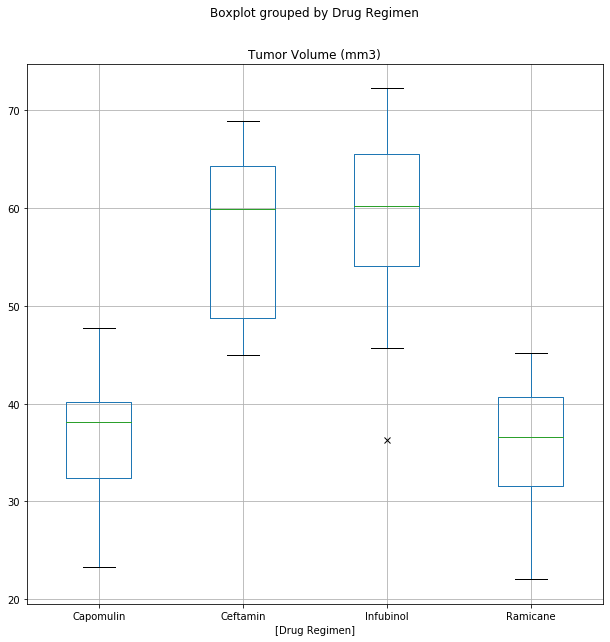

In [20]:
ftv_df.boxplot(column = ['Tumor Volume (mm3)'], by=['Drug Regimen'], figsize = (10,10), sym = 'x')
plt.show()

### Line and Scatter Plots

In [21]:
# first, let's get all the Capomulin mice.
cap_mice_df = clean_df.copy().loc[clean_df['Drug Regimen'] == 'Capomulin',:]

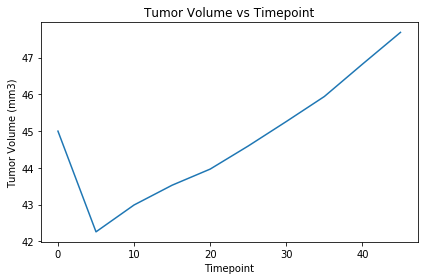

In [22]:
# The ask is a line plot for any Capomulin mouse.
# I'd like one that makes it to the end, and a quick peek shows i557 does just that.
line_i557_df = cap_mice_df.copy().loc[cap_mice_df['Mouse ID'] == 'i557', :]
line_i557_df = line_i557_df.loc[:,['Timepoint', 'Tumor Volume (mm3)']]

plt.plot(line_i557_df['Timepoint'], line_i557_df['Tumor Volume (mm3)'])
plt.title('Tumor Volume vs Timepoint')
plt.xlabel('Timepoint')
plt.ylabel('Tumor Volume (mm3)')
plt.tight_layout()
plt.show()

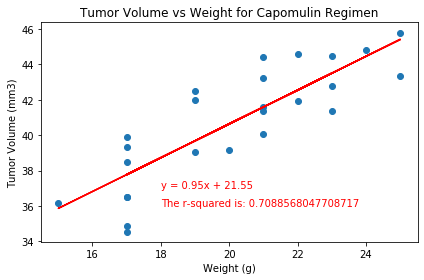

In [23]:
# now for the scatterplot
# Note that the readme asks for "average tumor volume", which I read as being different than "final tumor volume"
cap_avg = cap_mice_df.groupby('Mouse ID').mean()
x_values = cap_avg['Weight (g)']
y_values = cap_avg['Tumor Volume (mm3)']
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
r_note = f"The r-squared is: {rvalue**2}"
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq, (18,37),color="red")
plt.annotate(r_note, (18,36),color="red")
plt.title('Tumor Volume vs Weight for Capomulin Regimen')
plt.xlabel('Weight (g)')
plt.ylabel('Tumor Volume (mm3)')
plt.tight_layout()
plt.show()

### Observations and Insights
#### Observation #1
The average (mean) tumor volume correlates strongly to body weight for mice undergoing the Capomulin regimen.
The correlation is linear, with an r-squared value of 0.70886.

#### Observation #2
There was only one outlier among the final tumor volumes for the four most promising drug regimens. This single outlier was for mouse c326, which exited the study early after timepoint 5.

#### Observation #3
The median final tumor volumes for Ceftamin and Infubinol are very close to each other. The IQRs for those drug regimens overlap substantially.